In [106]:
# Import libraries
import os
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [107]:
# Define paths

USED_CAR = os.path.join(os.getcwd(), 'malaysia_used_cars.csv')

MODELS = os.path.join(os.getcwd(), 'models')

In [108]:
# Step 1: Data Loading
df = pd.read_csv(USED_CAR)
df.head()

,make,model,trim,car_type,year,mileage,transmission,fuel_type,engine_cc,battery_kWh,is_turbo,origin_country,location,condition,retail_price(RM),current_price(RM)
0,Perodua,Ativa,1.0 Turbo AV,Suv,2022,28499,CVT,Petrol,1.0,NaN,True,Malaysia,Melaka,4,82000,58202.29
1,Toyota,Camry,2.5 V,Sedan,2020,59347,Automatic,Hybrid,2.5,NaN,False,Japan,Kuala Lumpur,3,220000,113655.99
2,Toyota,Camry,2.0 E,Sedan,2024,7140,Automatic,Hybrid,2.0,NaN,False,Japan,Perlis,2,190000,119212.95
3,Perodua,Ativa,1.0 Turbo X,Suv,2024,5685,CVT,Petrol,1.0,NaN,True,Malaysia,Perak,3,72000,48286.77
4,Mazda,Mazda3,2.0 Sedan,Sedan,2017,127600,Automatic,Petrol,2.0,NaN,False,Japan,Kuala Lumpur,4,143000,53569.19


In [109]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               700 non-null    object 
 1   model              700 non-null    object 
 2   trim               700 non-null    object 
 3   car_type           700 non-null    object 
 4   year               700 non-null    int64  
 5   mileage            700 non-null    int64  
 6   transmission       700 non-null    object 
 7   fuel_type          700 non-null    object 
 8   engine_cc          554 non-null    float64
 9   battery_kWh        146 non-null    float64
 10  is_turbo           554 non-null    object 
 11  origin_country     700 non-null    object 
 12  location           700 non-null    object 
 13  condition          700 non-null    int64  
 14  retail_price(RM)   700 non-null    int64  
 15  current_price(RM)  700 non-null    float64
dtypes: float64(3), int64(4), o

,count,mean,std,min,25%,50%,75%,max
year,700.0,2020.662857,2.691170,2016.00,2018.0000,2021.000,2023.0000,2024.00
mileage,700.0,88245.110000,56172.830512,3547.00,42951.0000,80498.500,124788.0000,219534.00
engine_cc,554.0,1.651805,0.397286,1.00,1.4000,1.600,2.0000,2.50
battery_kWh,146.0,69.306575,16.311696,49.52,60.0000,64.700,76.6000,111.50
condition,700.0,3.375714,0.962967,1.00,3.0000,3.000,4.0000,5.00
retail_price(RM),700.0,173962.857143,100485.410113,34000.00,95000.0000,150000.000,250000.0000,490000.00
current_price(RM),700.0,77576.002900,45770.549106,10645.57,43298.0525,69208.825,105011.7125,292582.99


In [110]:
categ = [
    "make",
    "model",
    "trim",
    "car_type",
    "transmission",
    "fuel_type",
    "engine_cc",
    "is_turbo",
    "origin_country",
    "location",
    "condition"
]

conti = [
    "year",
    "mileage",
    "battery_kWh",
    "retail_price(RM)",
    "current_price(RM)"
]

In [111]:
# Missing data inspection
df.isna().sum()

# Checking duplicated - none
df.duplicated().sum()

np.int64(0)

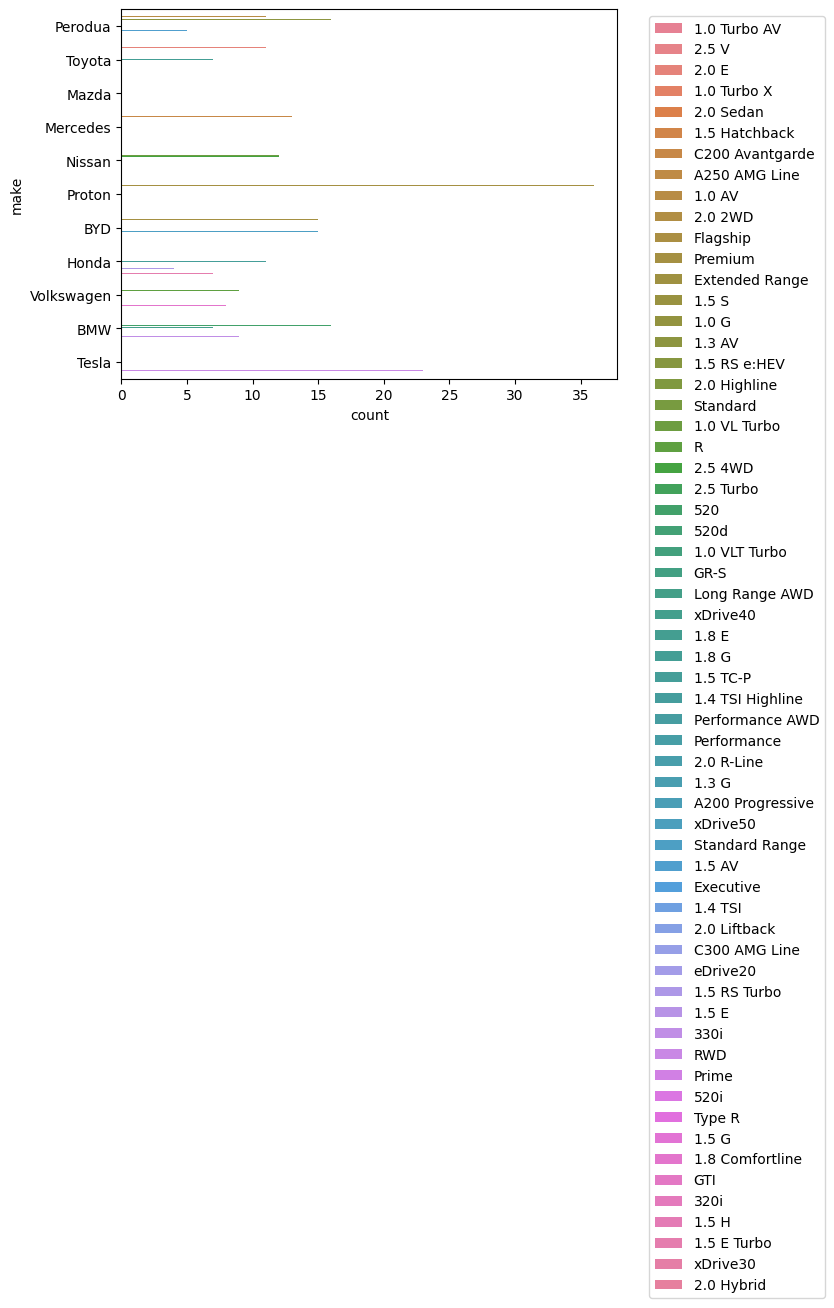

In [112]:
sns.countplot(df, y='make', hue='trim')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

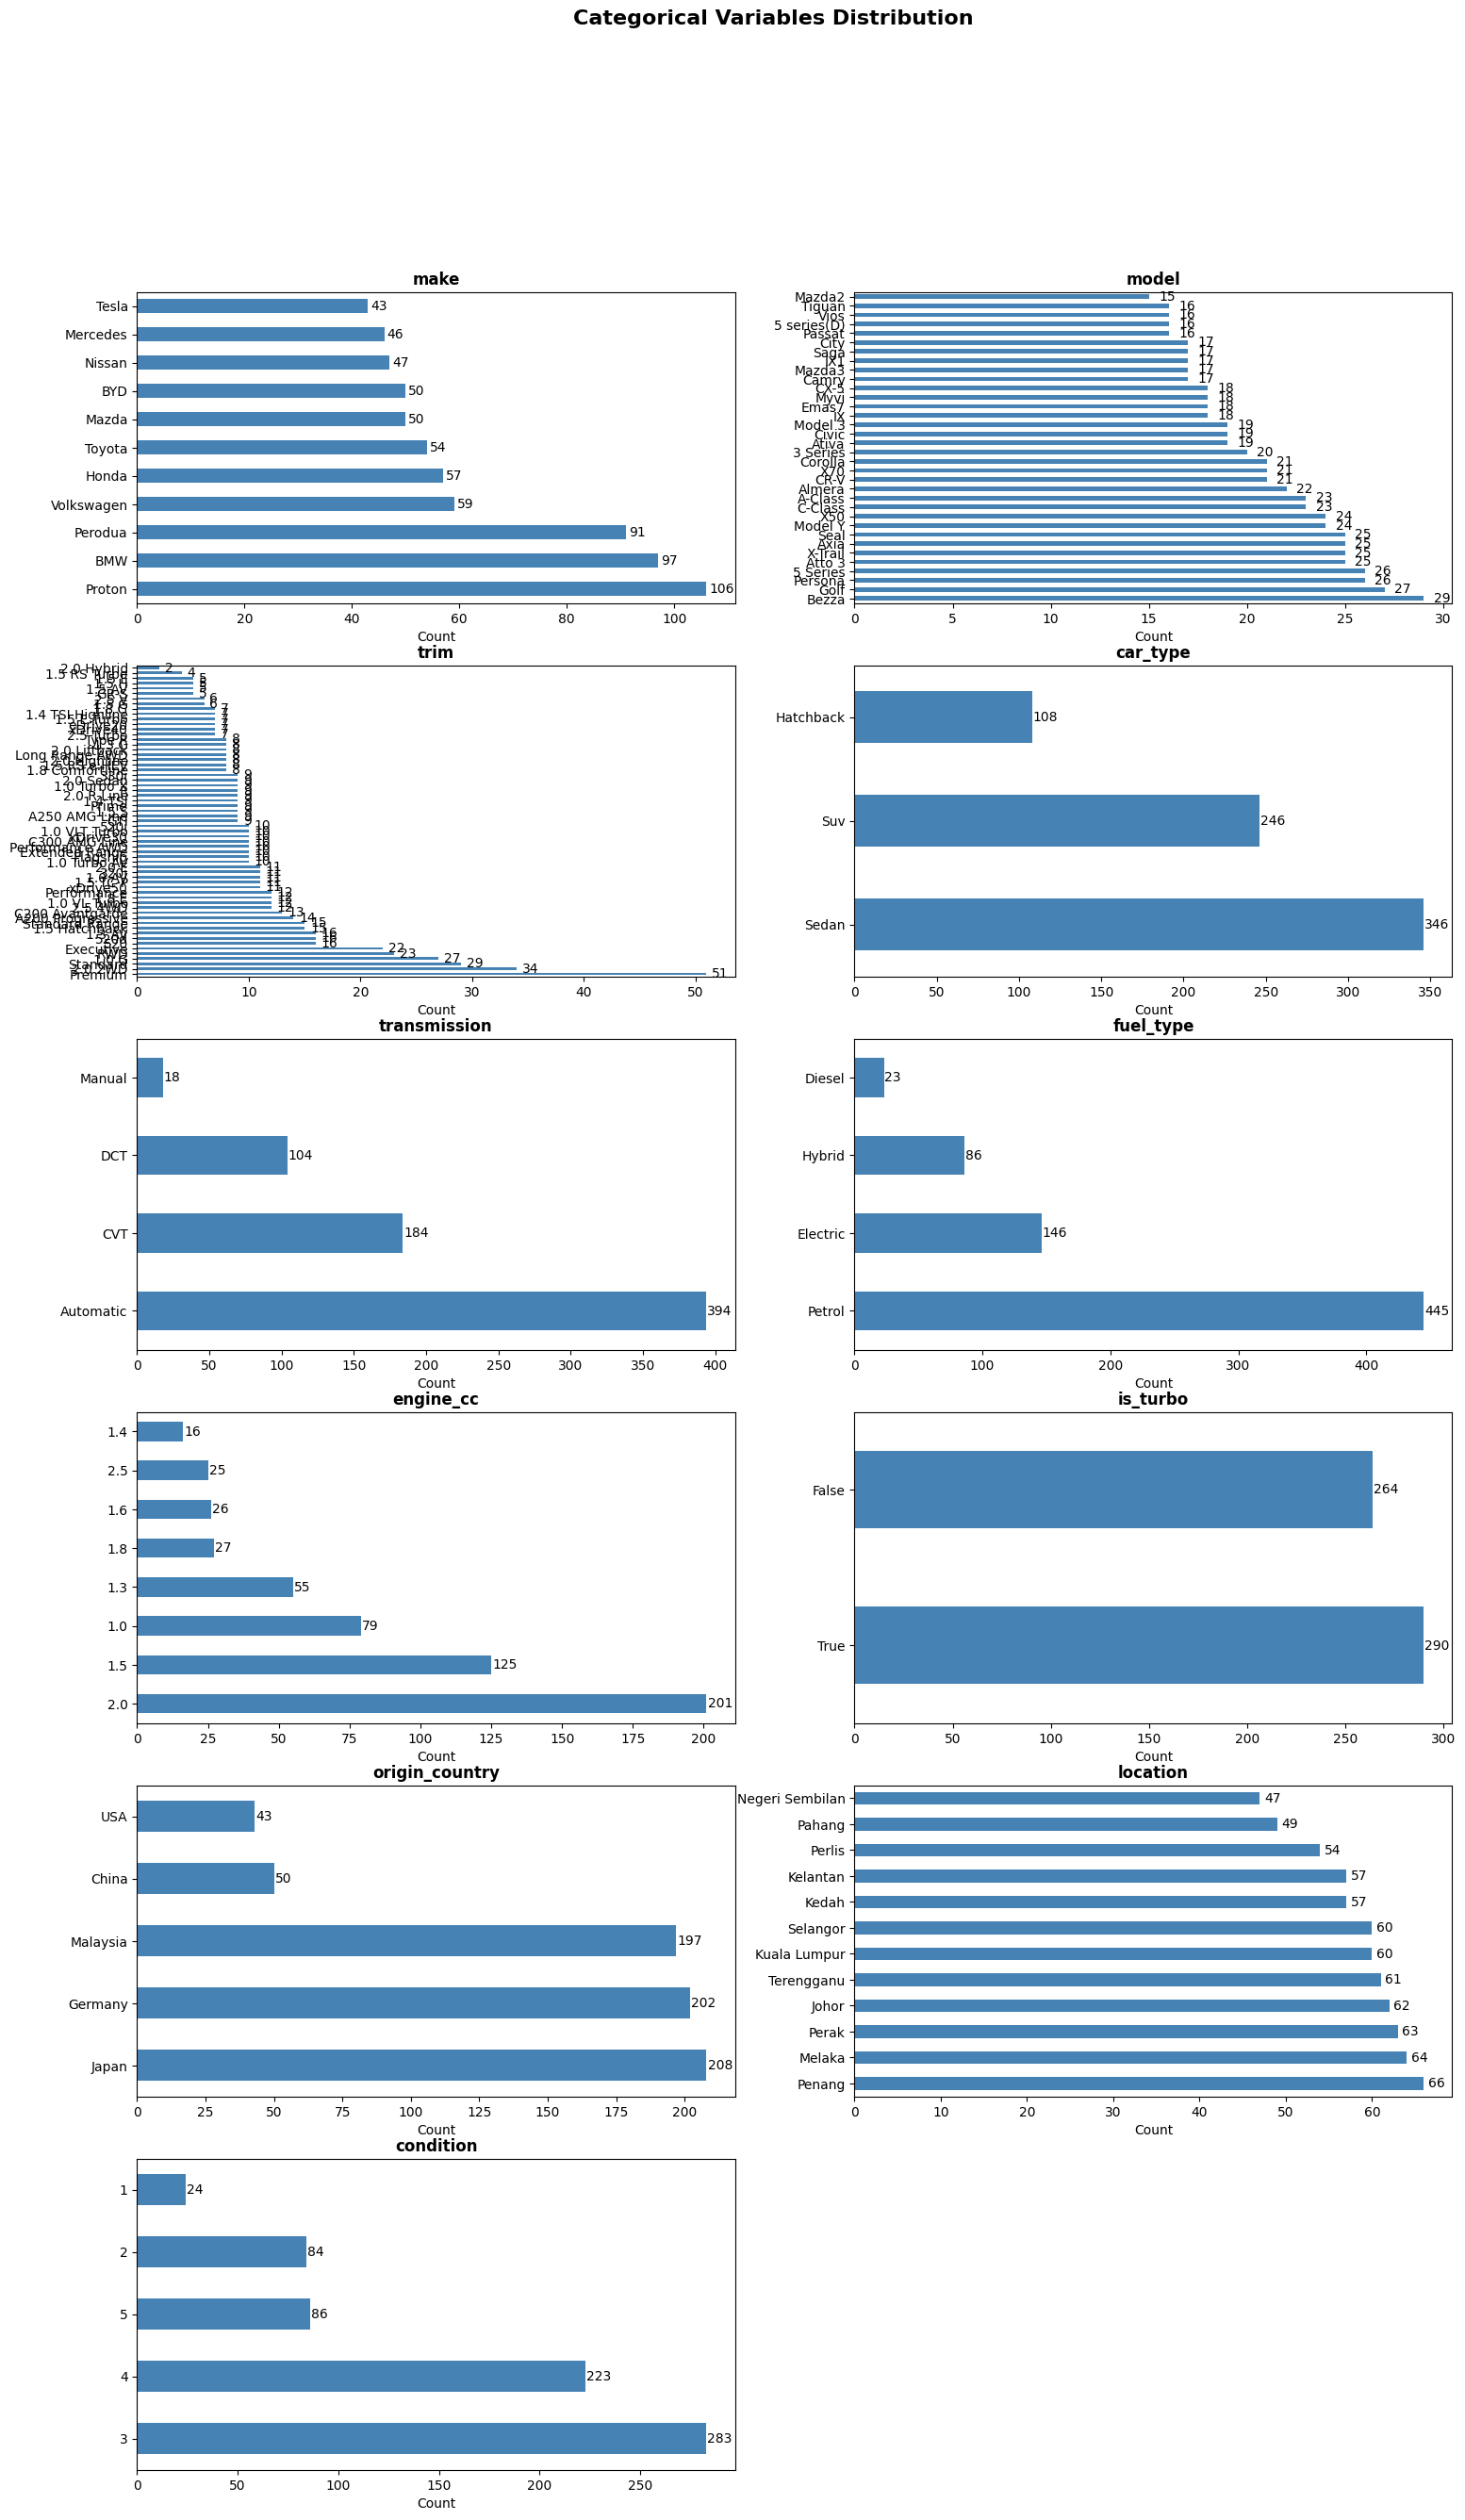

In [113]:
# Step 2: Data inspection
n_cols = 2
n_rows = math.ceil(len(categ) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(categ):
    value_counts = df[col].value_counts()
    
    # Horizontal bar plot
    value_counts.plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Count')
    axes[idx].set_ylabel('')
    
    # Add value labels
    for i, v in enumerate(value_counts):
        axes[idx].text(v + 0.5, i, str(v), va='center')

# Hide extra subplots
for idx in range(len(categ), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Categorical Variables Distribution', fontsize=16, fontweight='bold')
plt.show()

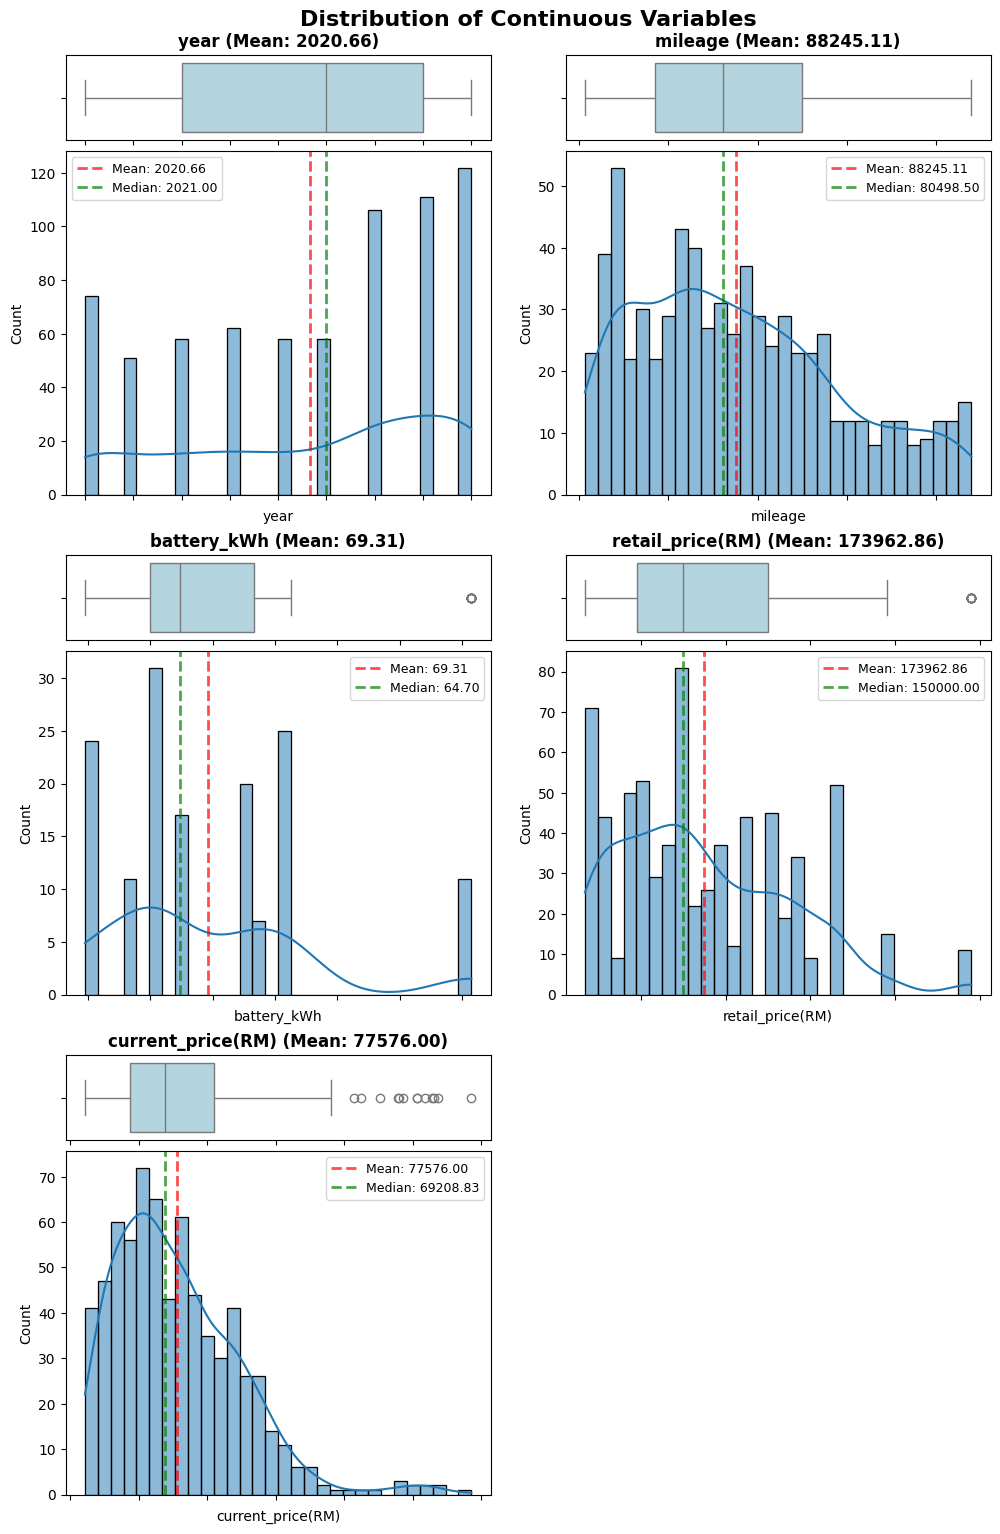

In [114]:
n_rows = math.ceil(len(conti) / n_cols)

fig = plt.figure(figsize=(n_cols * 5, n_rows * 5))

# Adjust these values to control spacing
horizontal_gap = 0.15  # Gap between columns (increase for more space)
vertical_gap = 0.12    # Gap between rows (increase for more space)

for idx, col in enumerate(conti):
    # Calculate position in grid
    row = idx // n_cols
    col_pos = idx % n_cols
    
    # Create GridSpec for this subplot (boxplot + histogram)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], 
                          hspace=0.05,
                          left=col_pos/n_cols + horizontal_gap/(2*n_cols),
                          right=(col_pos+1)/n_cols - horizontal_gap/(2*n_cols),
                          bottom=1 - (row+1)/n_rows + vertical_gap/(2*n_rows),
                          top=1 - row/n_rows - vertical_gap/(2*n_rows))
    
    # Boxplot
    ax_box = fig.add_subplot(gs[0])
    sns.boxplot(x=df[col], ax=ax_box, color='lightblue')
    ax_box.set_xlabel('')
    ax_box.set_xticklabels([])
    
    # Calculate statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    
    ax_box.set_title(f'{col} (Mean: {mean_val:.2f})', fontweight='bold', fontsize=12)
    
    # Histogram
    ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
    sns.histplot(df[col], kde=True, bins=30, ax=ax_hist)
    
    # Add mean and median lines
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax_hist.axvline(median_val, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {median_val:.2f}')
    ax_hist.legend(fontsize=9)
    ax_hist.set_xlabel(col)

plt.suptitle('Distribution of Continuous Variables', fontsize=16, fontweight='bold', y=1.01)
plt.show()

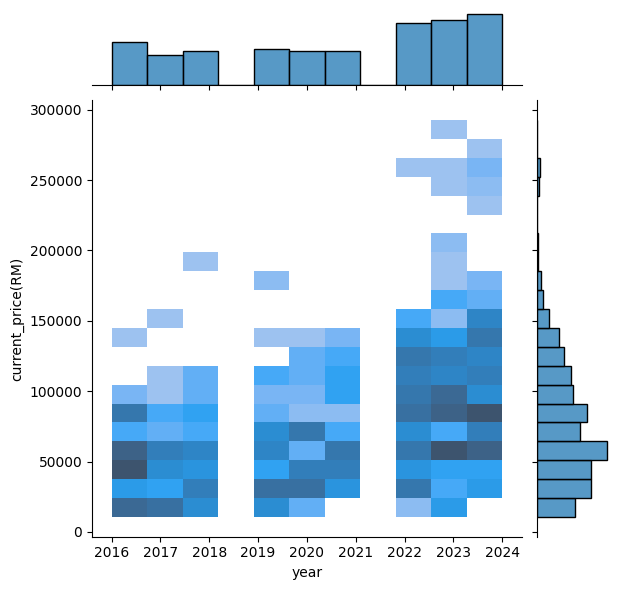

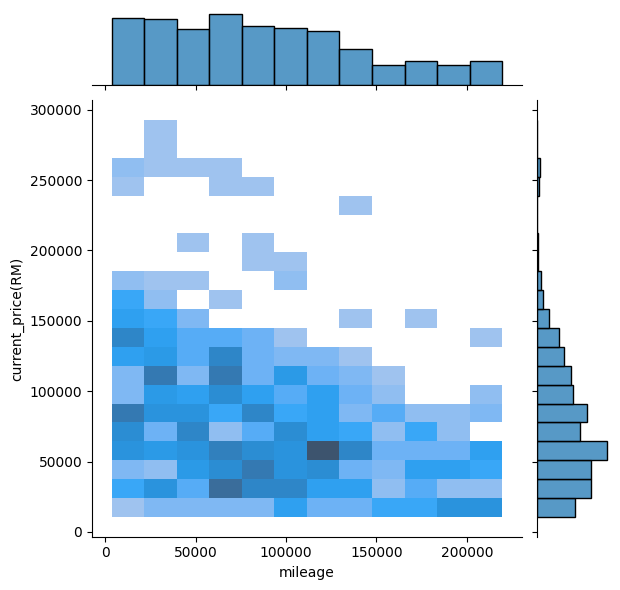

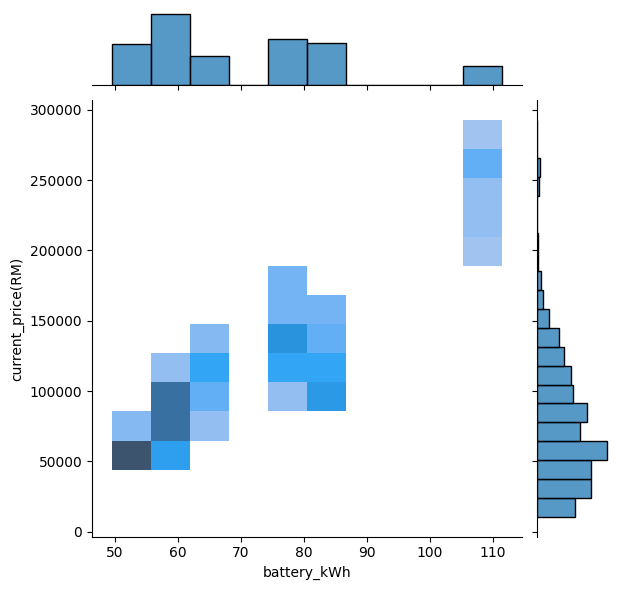

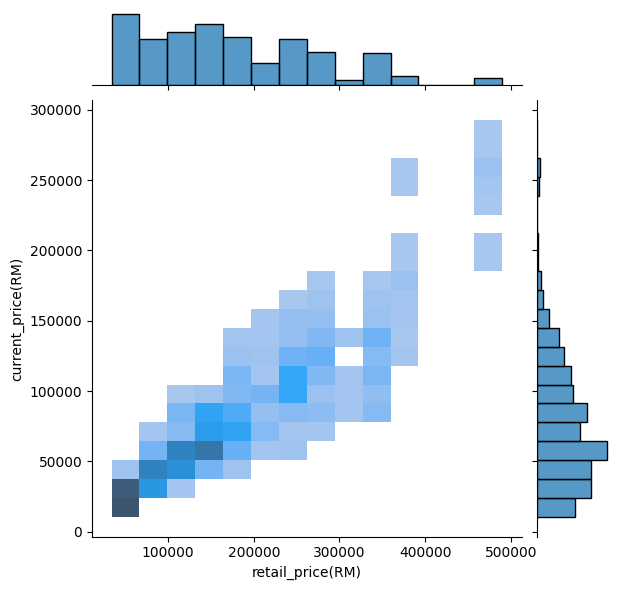

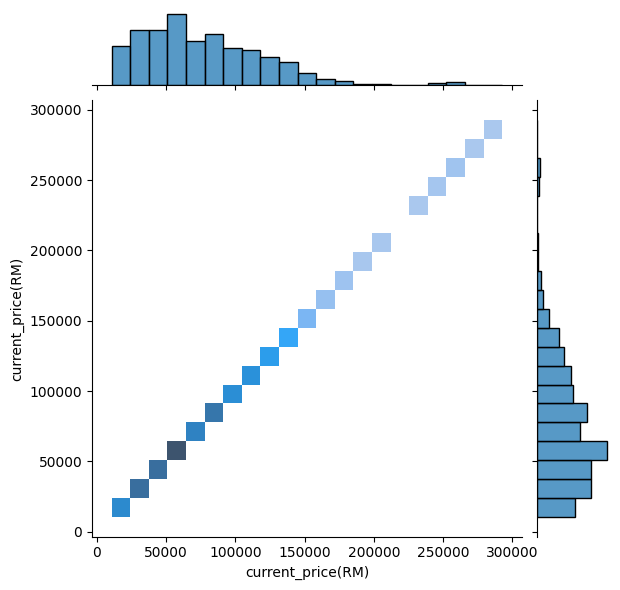

In [115]:
for con in conti:
    sns.jointplot(data=df, x=con, y="current_price(RM)", kind="hist")
    plt.show()

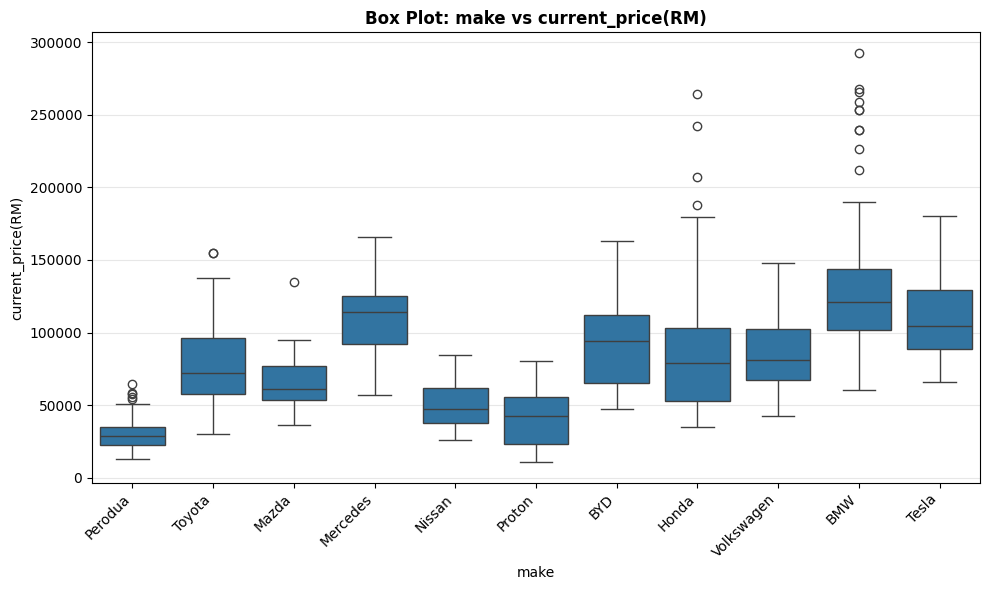

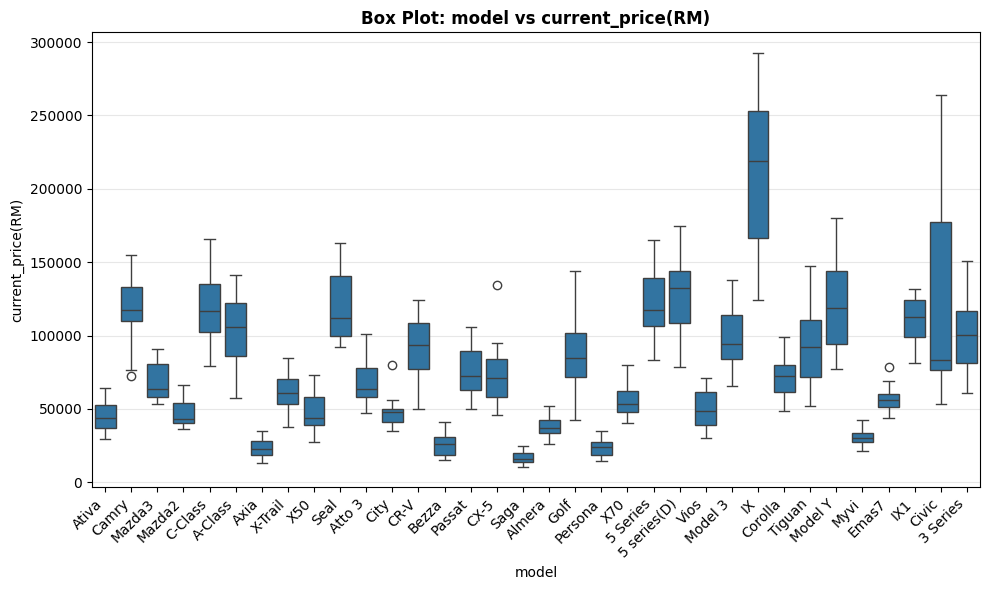

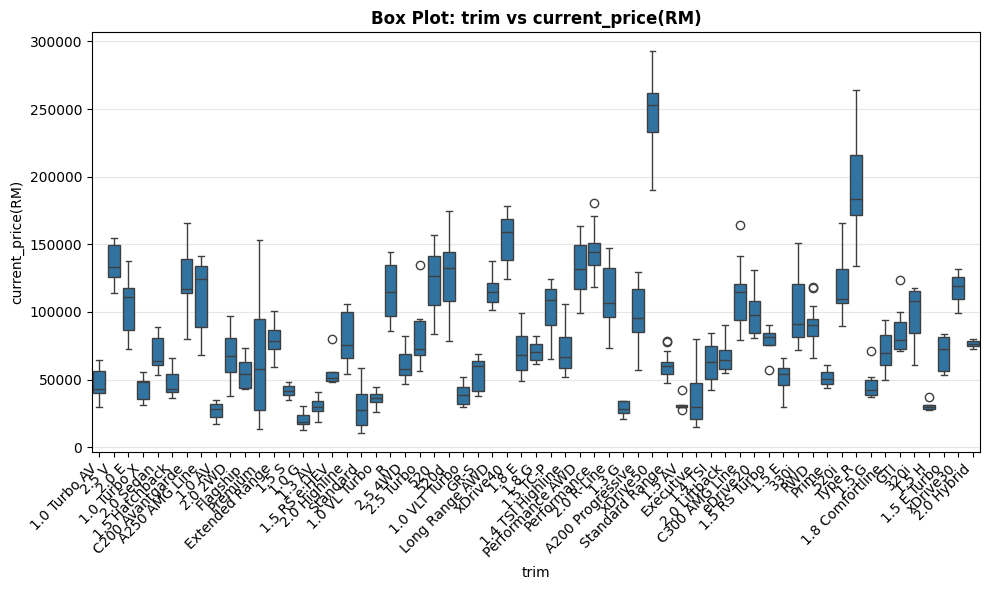

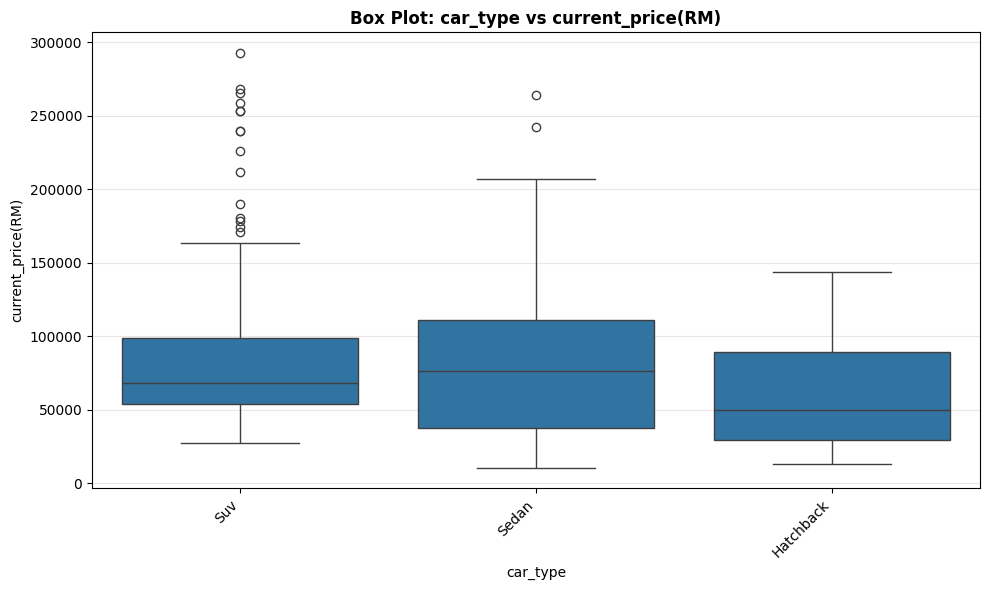

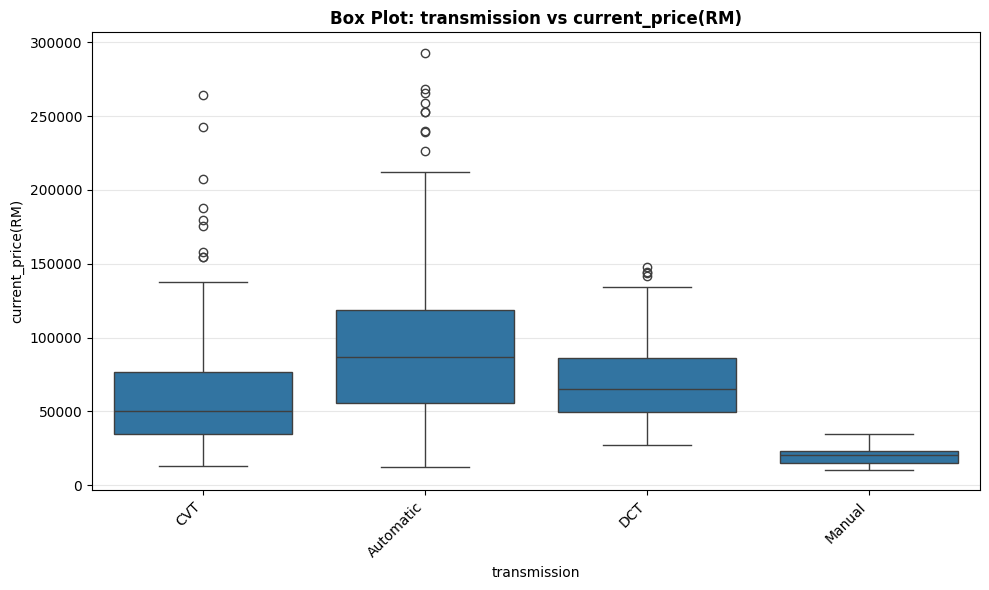

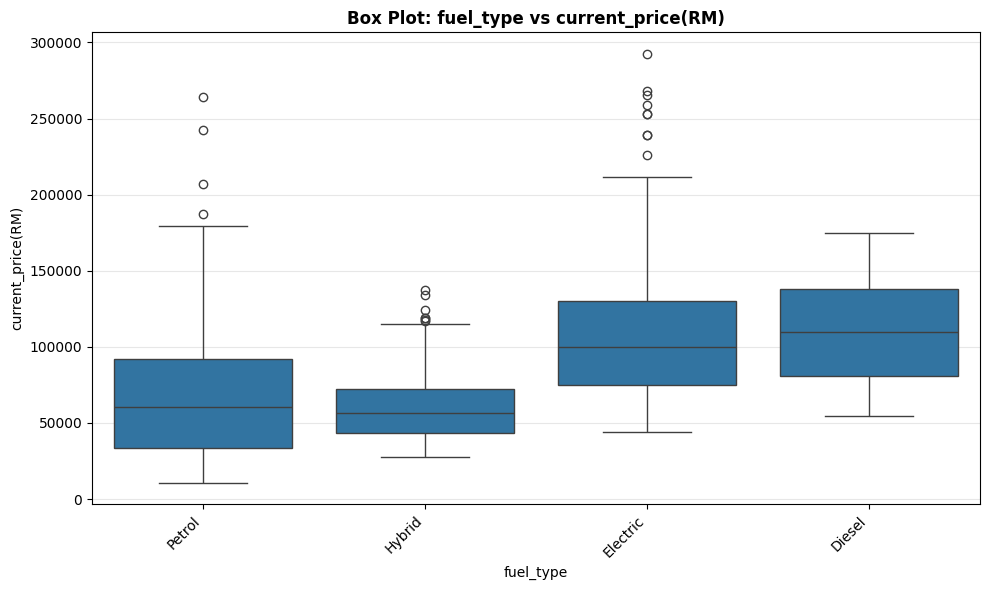

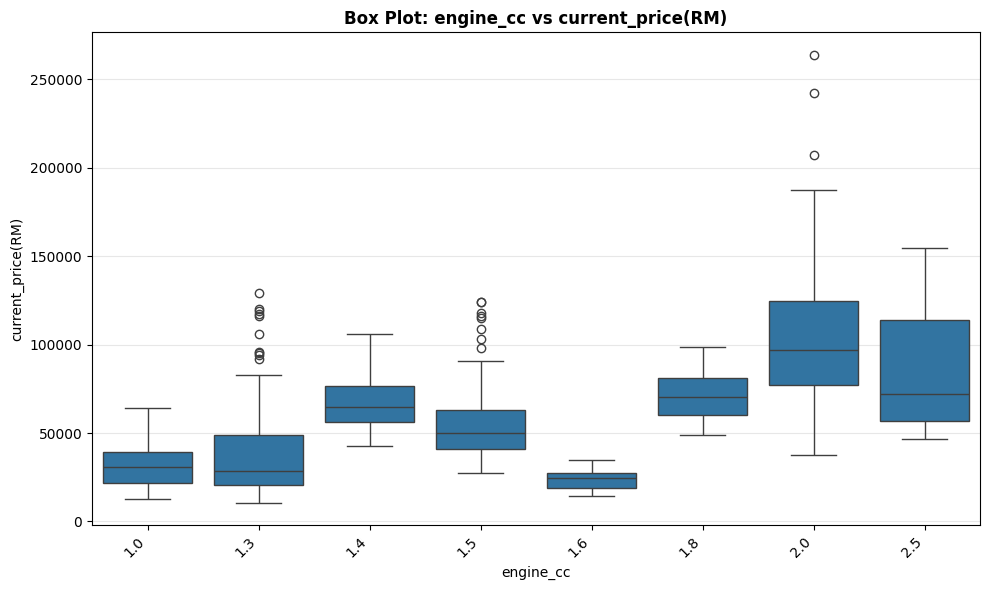

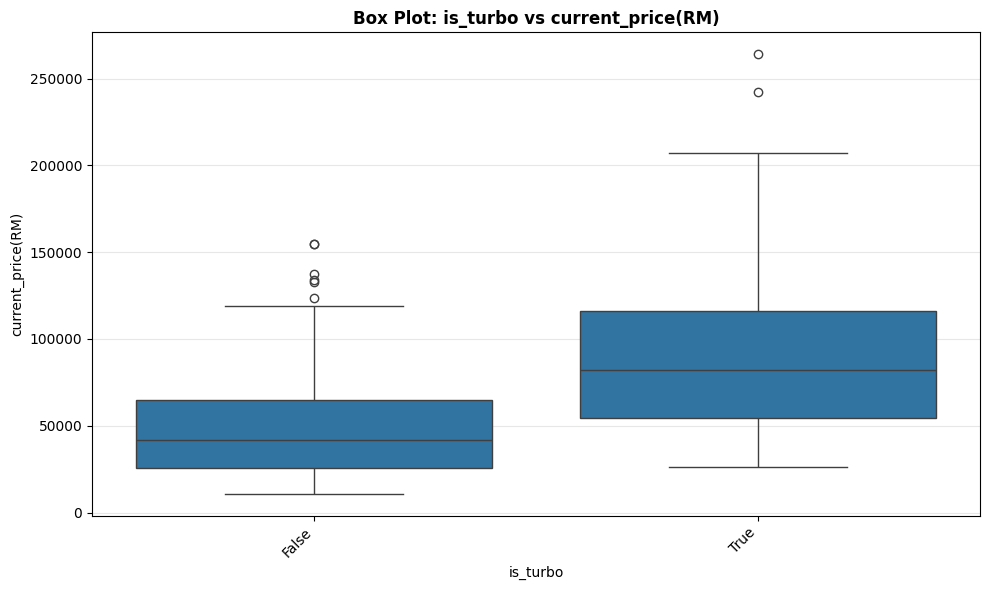

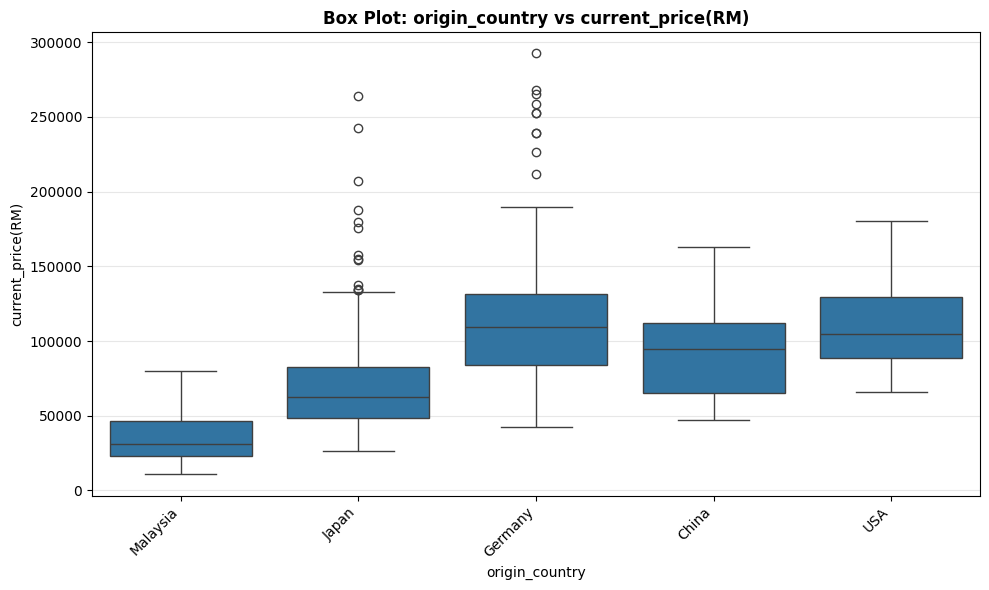

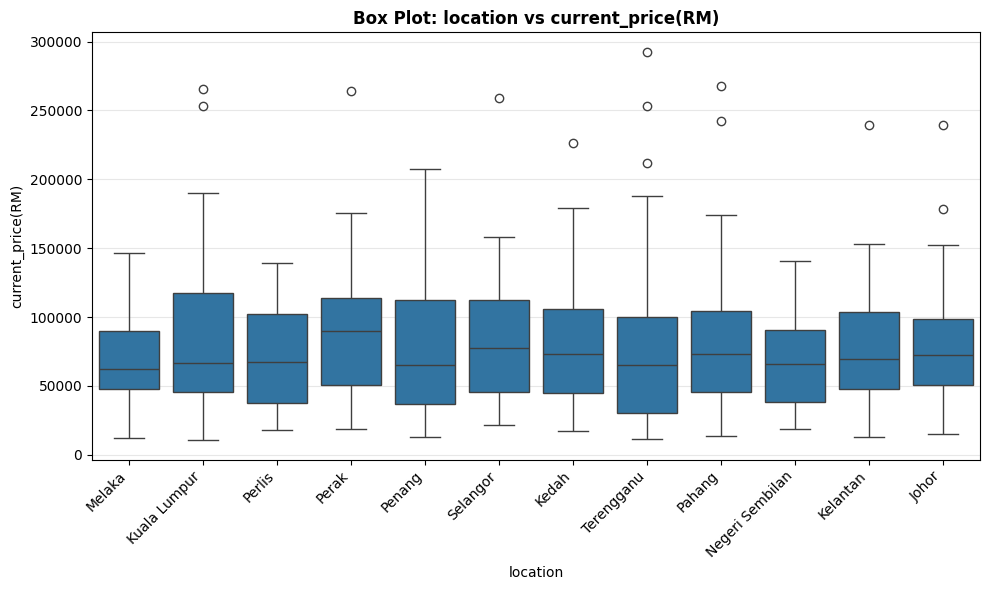

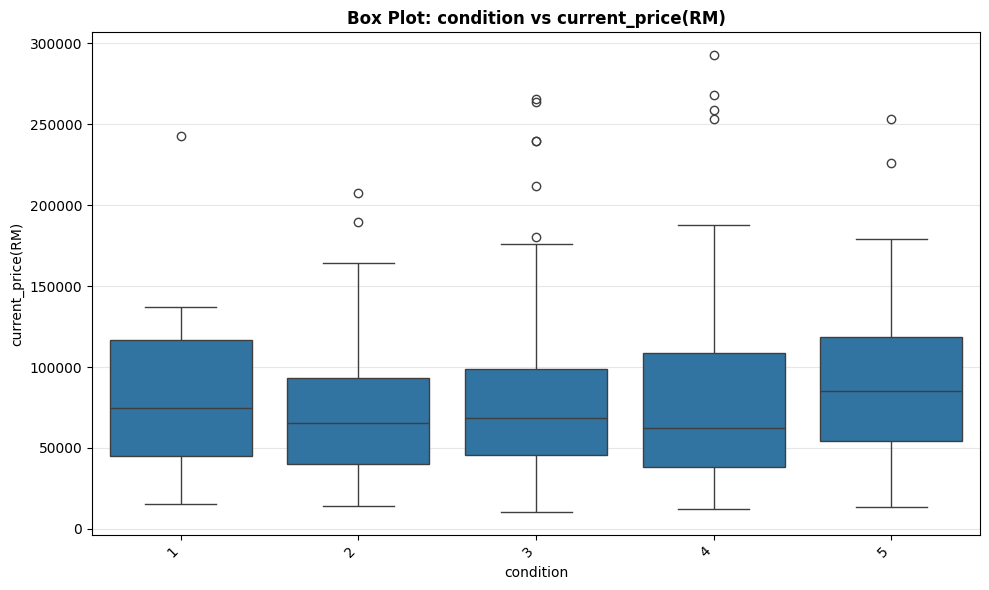

In [116]:
for cat in categ:
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot
    sns.boxplot(data=df, x=cat, y="current_price(RM)")  # Fixed: x and y were swapped
    plt.title(f'Box Plot: {cat} vs current_price(RM)', fontweight='bold')
    plt.xlabel(cat)
    plt.ylabel('current_price(RM)')
    plt.xticks(rotation=45, ha='right')  # Rotate labels if they're long
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [117]:
# Step 3: Data Cleaning      
        
# Label encode categorical features
bin_categ = categ.remove('engine_cc')

dft = df.copy()

for col in categ:
    
    if dft[col].isna().sum():
        dft[col].fillna(dft[col].mode()[0], inplace=True)

    le = LabelBinarizer() # turn word into numbers
    dft[col] = dft[col].astype(str)  # ensure consistent format (text format)
    dft[col] = le.fit_transform(dft[col]) # fit (learn all unique words) and transform word with number
    os.makedirs(MODELS, exist_ok=True)
    with open(os.path.join(MODELS, f'{col}_encoder.pkl'), 'wb') as f:
        pickle.dump(le, f)

C:\Users\Ailun\AppData\Local\Temp\ipykernel_17756\904109452.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dft[col].fillna(dft[col].mode()[0], inplace=True)
C:\Users\Ailun\AppData\Local\Temp\ipykernel_17756\904109452.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dft[col].fillna(dft[col].mode()[0], 

In [118]:
for con in conti:
    dft[con].fillna(dft[con].mean(), inplace=True)

C:\Users\Ailun\AppData\Local\Temp\ipykernel_17756\4169432148.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dft[con].fillna(dft[con].mean(), inplace=True)



--- Continuous vs Continuous Correlation ---
retail_price(RM)    0.901492
battery_kWh         0.450827
year                0.443020
mileage            -0.398045
dtype: float64


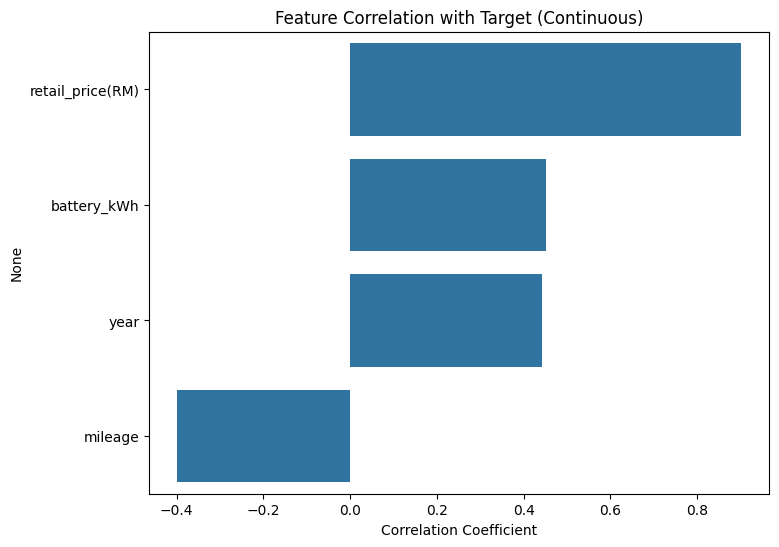


--- Continuous vs Categorical ---
make : 0.229
model : 0.007
trim : 0.019
car_type : 0.024
transmission : 0.090
fuel_type : 0.017
is_turbo : 0.246
origin_country : 0.010
location : 0.000
condition : 0.001

✅ Selected Features:
['is_turbo', 'mileage', 'make', 'year', 'retail_price(RM)', 'transmission', 'battery_kWh']


In [119]:
X = dft.drop(["current_price(RM)"], axis=1)
y = dft["current_price(RM)"]

# --- Continuous vs Continuous (Correlation with Target) ---
print("\n--- Continuous vs Continuous Correlation ---")
df_conti = dft[conti].drop(["current_price(RM)"], axis=1)
cor = df_conti.corrwith(y)  # correlation with target
cor = cor.sort_values(ascending=False)
print(cor)

# Visualize correlation with target
plt.figure(figsize=(8, 6))
sns.barplot(x=cor.values, y=cor.index)
plt.title('Feature Correlation with Target (Continuous)')
plt.xlabel('Correlation Coefficient')
plt.show()

# Select features above threshold
threshold = 0.3
sel_features = cor[abs(cor) > threshold].index.tolist()

# --- Continuous vs Categorical (via Linear Regression) ---
print("\n--- Continuous vs Categorical ---")
for i in categ:
    lr = LinearRegression()
    lr.fit(np.expand_dims(dft[i], axis=-1), y)
    score = lr.score(np.expand_dims(dft[i], axis=-1), y)
    print(f"{i} : {score:.3f}")
    if score > 0.05:  # low threshold for categorical influence
        sel_features.append(i)

# Remove duplicates
sel_features = list(set(sel_features))

print("\n✅ Selected Features:")
print(sel_features)

In [120]:
# Step 4: Features selection

X = X[sel_features]

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform
dft[sel_features] = scaler.fit_transform(dft[sel_features])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [121]:
X.columns

Index(['is_turbo', 'mileage', 'make', 'year', 'retail_price(RM)',
       'transmission', 'battery_kWh'],
      dtype='object')

In [122]:
# Step 5: Preprocessing, Training & Prediction

# Train a model (Random Forest)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
final_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, final_pred)
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
r2 = r2_score(y_test, final_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 7435.39
RMSE: 11987.61
R²: 0.941


In [123]:
print("\n" + "="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)

# Predictions
train_pred = model.predict(X_train)
final_pred = model.predict(X_test)

# Training Set Metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

# Test Set Metrics
test_mae = mean_absolute_error(y_test, final_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, final_pred))
test_r2 = r2_score(y_test, final_pred)

# Additional Metrics
mape = np.mean(np.abs((y_test - final_pred) / y_test)) * 100
residuals = y_test - final_pred

print("\nTRAINING SET:")
print(f"  MAE:  {train_mae:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  R²:   {train_r2:.3f}")

print("\nTEST SET:")
print(f"  MAE:  {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R²:   {test_r2:.3f}")
print(f"  MAPE: {mape:.2f}%")

print("\nOVERFITTING CHECK:")
print(f"R² Difference: {train_r2 - test_r2:.3f}")
if (train_r2 - test_r2) > 0.1:
    print("Possible overfitting detected!")
else:
    print("Model generalizes well")


MODEL PERFORMANCE METRICS

TRAINING SET:
  MAE:  2520.91
  RMSE: 3438.99
  R²:   0.994

TEST SET:
  MAE:  7435.39
  RMSE: 11987.61
  R²:   0.941
  MAPE: 9.18%

OVERFITTING CHECK:
R² Difference: 0.052
Model generalizes well


In [124]:
# Save model
os.makedirs(MODELS, exist_ok=True)
with open(os.path.join(MODELS, f'RF_regression.pkl'), 'wb') as f:
    pickle.dump(model, f)

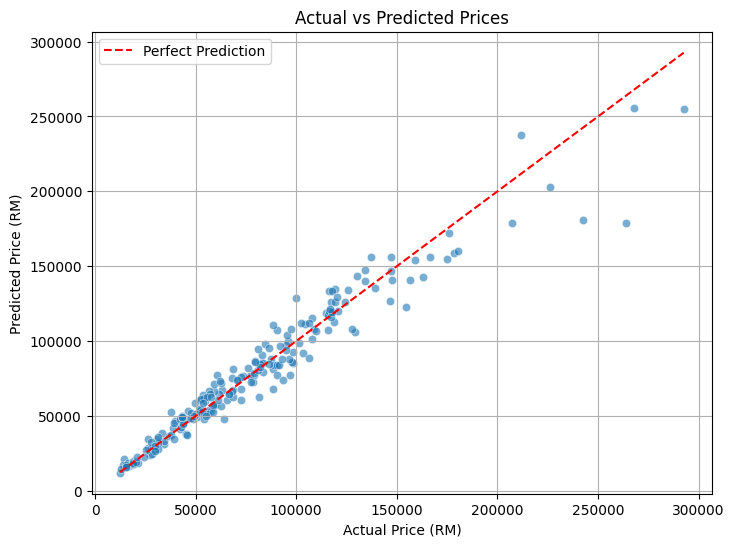

In [125]:
# Step 6: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=final_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Price (RM)")
plt.ylabel("Predicted Price (RM)")
plt.title(f"Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()